In [1]:
!pip install tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 51kB/s 
     |████████████████████████████████| 4.3MB 27.7MB/s 
     |████████████████████████████████| 501kB 44.0MB/s 


In [2]:
import time
import numpy as np

import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.0.0-rc1


## `tf.function` による高速化

`tf.function`でどのくらい学習時間が速くなるのかを検証。以下のTrainer クラスを使って学習（と評価）を行い、所要時間を計る。  
学習データとしてはfashion-MNIST を用いる。

In [0]:
class Trainer(object):
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = keras.losses.SparseCategoricalCrossentropy()

        self.train_metric_loss = keras.metrics.Mean()
        self.train_metric_accuracy = keras.metrics.SparseCategoricalAccuracy()
        self.validation_metric_loss = keras.metrics.Mean()
        self.validation_metric_accuracy = keras.metrics.SparseCategoricalAccuracy()

        self.history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}

    def train_step(self, x_batch, y_batch):
        with tf.GradientTape() as tape:
            y_pred = self.model(x_batch, training=True)
            loss = self.loss_fn(y_batch, y_pred)

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        self.train_metric_loss(loss)
        self.train_metric_accuracy(y_batch, y_pred)

    def eval_step(self, x_batch, y_batch):
        y_pred = self.model(x_batch, training=False)
        loss = self.loss_fn(y_batch, y_pred)

        self.validation_metric_loss(loss)
        self.validation_metric_accuracy(y_batch, y_pred)

    def train(self, epochs, train_dataset, validation_dataset, verbose=True):
        for epoch in range(epochs):
            for x_batch, y_batch in train_dataset:
                self.train_step(x_batch, y_batch)

            train_loss = self.train_metric_loss.result().numpy()
            train_accuracy = self.train_metric_accuracy.result().numpy()

            self.train_metric_loss.reset_states()
            self.train_metric_accuracy.reset_states()

            for x_batch, y_batch in validation_dataset:
                self.eval_step(x_batch, y_batch)

            validation_loss = self.validation_metric_loss.result().numpy()
            validation_accuracy = self.validation_metric_accuracy.result().numpy()

            self.validation_metric_loss.reset_states()
            self.validation_metric_accuracy.reset_states()

            if verbose:
                train_log = "epoch={}: train loss={:.3f}, val_loss={:.3f}, train_acc={:.3f}, val_acc={:.3f}".format(
                    epoch + 1, 
                    train_loss, 
                    validation_loss, 
                    train_accuracy, 
                    validation_accuracy)
                print(train_log)
            
            self.history["loss"].append(train_loss)
            self.history["val_loss"].append(validation_loss)
            self.history["accuracy"].append(train_accuracy)
            self.history["val_accuracy"].append(validation_accuracy)

In [0]:
# 学習時の共通パラメータ
batch_size = 128
shuffle_buffer_size = 10000

num_epochs = 10

# 計測回数
num_try = 5 

### NN

普通の（畳み込みでない）ニューラルネットの場合。

In [5]:
# データの準備 
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28 * 28) / 255
X_test = X_test.astype(np.float32).reshape(-1, 28 * 28) / 255
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=shuffle_buffer_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
# 使用するニューラルネット
def build_nn_model():
    model = keras.Sequential([
        keras.layers.Dense(20, activation="relu", input_shape=(28 * 28,)),
        keras.layers.Dense(20, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ])
    
    return model

In [0]:
nn_elapsed_times = dict()

In [8]:
# decoration なし

nn_elapsed_times["without-decoration"] = []

for _ in range(num_try):
    model = build_nn_model()

    optimizer = keras.optimizers.Adam()
    trainer = Trainer(model, optimizer)

    start = time.time()
    trainer.train(num_epochs, train_dataset, test_dataset, verbose=False)
    end = time.time()

    nn_elapsed_times["without-decoration"].append(end - start)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# decoration あり

nn_elapsed_times["with-decoration"] = []

for _ in range(num_try):
    model = build_nn_model()

    optimizer = keras.optimizers.Adam()
    trainer = Trainer(model, optimizer)

    # tf.function をTrainer.train_step とTrainer.eval_step に適用
    trainer.train_step = tf.function(trainer.train_step)
    trainer.eval_step = tf.function(trainer.eval_step)

    start = time.time()
    trainer.train(num_epochs, train_dataset, test_dataset, verbose=False)
    end = time.time()

    nn_elapsed_times["with-decoration"].append(end - start)

In [0]:
# keras.Sequential のfit

nn_elapsed_times["sequential"] = []

for _ in range(num_try):
    model = build_nn_model()

    optimizer = keras.optimizers.Adam()
    
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    start = time.time()
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    end = time.time()

    nn_elapsed_times["sequential"].append(end - start)

In [11]:
nn_elapsed_times

{'sequential': [18.859631538391113,
  18.71006989479065,
  18.8301739692688,
  18.82243299484253,
  18.94554352760315],
 'with-decoration': [14.076695442199707,
  13.636998176574707,
  13.199131488800049,
  13.490076065063477,
  13.256957530975342],
 'without-decoration': [84.63697075843811,
  85.09200167655945,
  84.82398796081543,
  85.80450463294983,
  86.54808163642883]}

In [12]:
for key in nn_elapsed_times.keys():
    print(key + ": ", np.mean(nn_elapsed_times[key]))

without-decoration:  85.38110933303832
with-decoration:  13.531971740722657
sequential:  18.833570384979247


### CNN

畳み込みニューラルネットの場合。

In [0]:
# データの準備
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28, 28, 1) / 255
X_test = X_test.astype(np.float32).reshape(-1, 28, 28, 1) / 255
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=shuffle_buffer_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

In [0]:
def build_cnn_model():
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.SpatialDropout2D(0.3),
        keras.layers.Conv2D(64, (3, 3), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ])

    return model

In [0]:
cnn_elapsed_times = dict()

In [0]:
# decoration なし

cnn_elapsed_times["without-decoration"] = []

for _ in range(num_try):
    model = build_cnn_model()

    optimizer = keras.optimizers.Adam()
    trainer = Trainer(model, optimizer)

    start = time.time()
    trainer.train(num_epochs, train_dataset, test_dataset, verbose=False)
    end = time.time()

    cnn_elapsed_times["without-decoration"].append(end - start)

In [0]:
# decoration あり

cnn_elapsed_times["with-decoration"] = []

for _ in range(num_try):
    model = build_cnn_model()

    optimizer = keras.optimizers.Adam()
    trainer = Trainer(model, optimizer)

    # tf.function をTrainer.train_step とTrainer.eval_step に適用
    trainer.train_step = tf.function(trainer.train_step)
    trainer.eval_step = tf.function(trainer.eval_step)

    start = time.time()
    trainer.train(num_epochs, train_dataset, test_dataset, verbose=False)
    end = time.time()

    cnn_elapsed_times["with-decoration"].append(end - start)

In [0]:
# keras.Sequential のfit

cnn_elapsed_times["sequential"] = []

for _ in range(num_try):
    model = build_cnn_model()

    optimizer = keras.optimizers.Adam()
    
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    start = time.time()
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    end = time.time()

    cnn_elapsed_times["sequential"].append(end - start)

In [19]:
cnn_elapsed_times

{'sequential': [45.43068075180054,
  45.68883037567139,
  45.86645483970642,
  45.573588848114014,
  45.23062086105347],
 'with-decoration': [34.94926643371582,
  34.71097922325134,
  34.615787982940674,
  34.6799750328064,
  34.75037908554077],
 'without-decoration': [161.35337018966675,
  157.6680943965912,
  158.73536801338196,
  157.66677904129028,
  158.84630155563354]}

In [20]:
for key in cnn_elapsed_times.keys():
    print(key + ": ", np.mean(cnn_elapsed_times[key]))

without-decoration:  158.85398263931273
with-decoration:  34.741277551651
sequential:  45.558035135269165


### 集計とプロット

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
nn_results = pd.DataFrame(nn_elapsed_times)
nn_results = nn_results.melt(value_vars=nn_results.columns, var_name="train type", value_name="elapsed time")
nn_results

,train type,elapsed time
0,without-decoration,84.636971
1,without-decoration,85.092002
2,without-decoration,84.823988
3,without-decoration,85.804505
4,without-decoration,86.548082
5,with-decoration,14.076695
6,with-decoration,13.636998
7,with-decoration,13.199131
8,with-decoration,13.490076
9,with-decoration,13.256958


In [23]:
nn_results.groupby("train type").describe()

elapsed time             ...                      
                          count       mean  ...        75%        max
train type                                  ...                      
sequential                  5.0  18.833570  ...  18.859632  18.945544
with-decoration             5.0  13.531972  ...  13.636998  14.076695
without-decoration          5.0  85.381109  ...  85.804505  86.548082

[3 rows x 8 columns]

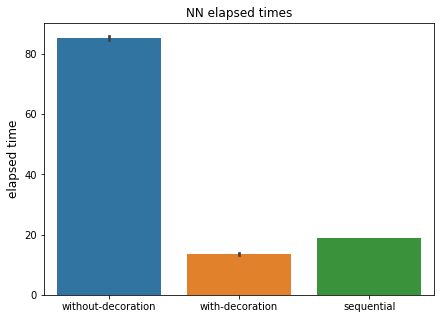

In [24]:
plt.figure(figsize=(7, 5))
sns.barplot("train type", "elapsed time", data=nn_results, 
            order=["without-decoration", "with-decoration", "sequential"])
plt.xlabel(None)
plt.ylabel("elapsed time", fontsize=12)
plt.title("NN elapsed times", fontsize=12)
plt.savefig("NN_elapsed_times_result.png", dpi=200);

In [25]:
cnn_results = pd.DataFrame(cnn_elapsed_times)
cnn_results = cnn_results.melt(value_vars=cnn_results.columns, var_name="train type", value_name="elapsed time")
cnn_results

,train type,elapsed time
0,without-decoration,161.353370
1,without-decoration,157.668094
2,without-decoration,158.735368
3,without-decoration,157.666779
4,without-decoration,158.846302
5,with-decoration,34.949266
6,with-decoration,34.710979
7,with-decoration,34.615788
8,with-decoration,34.679975
9,with-decoration,34.750379


In [26]:
cnn_results.groupby("train type").describe()

elapsed time              ...                        
                          count        mean  ...         75%         max
train type                                   ...                        
sequential                  5.0   45.558035  ...   45.688830   45.866455
with-decoration             5.0   34.741278  ...   34.750379   34.949266
without-decoration          5.0  158.853983  ...  158.846302  161.353370

[3 rows x 8 columns]

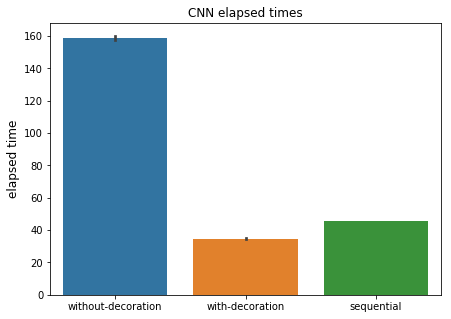

In [27]:
plt.figure(figsize=(7, 5))
sns.barplot("train type", "elapsed time", data=cnn_results, 
            order=["without-decoration", "with-decoration", "sequential"])
plt.xlabel(None)
plt.ylabel("elapsed time", fontsize=12)
plt.title("CNN elapsed times", fontsize=12)
plt.savefig("CNN_elapsed_times_result.png", dpi=200);